## Preprocess the imaging dataset

In [18]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import os
import openslide
from PIL import Image, ImageOps

March 1: Specify the path to the folder with all the data organized by cases. Specify the destination data path to store a list of all cases that had valid images. Specify the image path for where to store the processed, resized JPEG images.

In [45]:
ORGANIZED_BY_CASE_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_by_cases"
DESTINATION_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_images_data.csv"
IMAGE_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/imaging_data/experimental"

In [4]:
cases = os.listdir(ORGANIZED_BY_CASE_PATH)
cases[0:10]

['TCGA-35-4122',
 'TCGA-75-6203',
 'TCGA-75-5146',
 'TCGA-78-8648',
 'TCGA-55-A4DG',
 'TCGA-MP-A4SY',
 'TCGA-67-3771',
 'TCGA-44-A479',
 'TCGA-78-7156',
 'TCGA-55-7724']

We want to include only DX images, and not TS images. DX images are better for computational studies.

In [51]:
def get_FFPE_images(case):
    img_files = os.listdir(os.path.join(ORGANIZED_BY_CASE_PATH, case, "images"))
    for f in img_files:
        if (f.split('.')[0][-3:-1] == 'DX'):
            return os.path.join(ORGANIZED_BY_CASE_PATH, case, 'images', f)
    print("No DX found for case",case)
    return None

In [52]:
j = 0
case_and_image = {}
for case in cases:
    n = get_FFPE_images(case)
    if n is not None:
        case_and_image[case] = n
        j+=1
print(f"{j} cases out of {len(cases)} have valid images")

No DX found for case TCGA-50-5049
No DX found for case TCGA-62-8394
No DX found for case TCGA-50-5933
No DX found for case TCGA-50-5936
No DX found for case TCGA-91-6831
No DX found for case TCGA-91-8499
No DX found for case TCGA-50-5932
No DX found for case TCGA-91-6848
No DX found for case TCGA-91-6836
No DX found for case TCGA-05-4389
No DX found for case TCGA-50-5930
No DX found for case TCGA-50-5072
No DX found for case TCGA-44-8117
No DX found for case TCGA-97-8174
No DX found for case TCGA-67-3776
No DX found for case TCGA-50-6595
No DX found for case TCGA-44-8120
No DX found for case TCGA-91-6835
No DX found for case TCGA-91-8496
No DX found for case TCGA-97-8176
No DX found for case TCGA-50-8460
No DX found for case TCGA-50-5935
No DX found for case TCGA-91-6847
No DX found for case TCGA-50-5944
No DX found for case TCGA-91-7771
No DX found for case TCGA-91-6849
No DX found for case TCGA-50-5941
No DX found for case TCGA-62-8395
No DX found for case TCGA-91-6840
No DX found fo

First, get information regarding the dimensions of al the images.

In [59]:
total_cases = len(case_and_image)
orig_dims = []
for i,c in enumerate(case_and_image):
    svs = openslide.OpenSlide(case_and_image[c])
    orig_dims.append(svs.level_dimensions[0])
    print(f"{i}/{total_cases}")
flipped_data = [(y, x) if x < y else (x, y) for x, y in orig_dims]
aspect_ratio = [x/y for x, y in flipped_data]

Median aspect ratio: 1.3587662337662338


In [ ]:
med_aspect_ratio = round(np.median(aspect_ratio), 4)
print(f"Median aspect ratio: {med_aspect_ratio}")

We use the median aspect ratio to determine an output image shape that avoids adding distortion to as many images as possible. 

In [38]:
aspect_ratio = med_aspect_ratio
# SPECIFY THE OUTPUT DIMENSION FOR HEIGHT
target_h = 300
target_w = (int)(aspect_ratio * target_h)
print("Dimensions of output image", target_w, target_h)

405 300


Now we must rescale all the slide images to these dimensions. (This might take a few minutes; if using more than 500 images, if might be worth using sbatch)

In [50]:
for i,c in enumerate(case_and_image):
    # open slide
    svs = openslide.OpenSlide(case_and_image[c])
    # get a thumbnail from svs (ensure this constant is strictly less than all dims across images)
    thumbnail = svs.get_thumbnail((1000, 1000))
    dim_tn_x, dim_tn_y = thumbnail.size
    # rotate images that are vertical
    if dim_tn_y > dim_tn_x:
        thumbnail = thumbnail.transpose(method=Image.Transpose.ROTATE_90)
    # resize image and use padding to ensure that target size is guarenteed
    resized_image = ImageOps.pad(thumbnail.resize((target_w, target_h)), size=(target_w, target_h))
    output_path = os.path.join(IMAGE_PATH, f"{c}.jpeg")
    assert resized_image.size[0] == target_w
    assert resized_image.size[1] == target_h
    resized_image.save(output_path)

Store a reference csv so we know what cases had images we generated.

In [53]:
all_images_data = pd.DataFrame.from_dict(case_and_image, orient='index', columns=['image_path']).reset_index(\
                                                      ).rename(columns={'index':'case_id'})
all_images_data.head()

,case_id,image_path
0,TCGA-35-4122,/users/anair27/data/TCGA_Data/project_LUAD/dat...
1,TCGA-75-6203,/users/anair27/data/TCGA_Data/project_LUAD/dat...
2,TCGA-75-5146,/users/anair27/data/TCGA_Data/project_LUAD/dat...
3,TCGA-78-8648,/users/anair27/data/TCGA_Data/project_LUAD/dat...
4,TCGA-55-A4DG,/users/anair27/data/TCGA_Data/project_LUAD/dat...


In [54]:
all_images_data.to_csv(DESTINATION_DATA_PATH)

All done! Ignore below (old code) for now. TODO: Remove and clean up below.

---

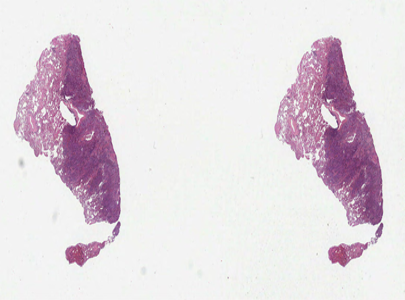

In [37]:
resized_image = ImageOps.pad(thumbnail.resize((target_w, target_h)), size=(target_w, target_h))
resized_image

In [40]:
resized_image.size

(405, 300)

In [44]:
resized_image.save(os.path.join('/users/anair27/data/anair27/singh-lab-TCGA-project/multiomic-model-tcga', "test_slide.jpeg"))

In [62]:
w, h = svs.level_dimensions[0]
w,h

(159234, 70182)

In [ ]:
svs.read_region((0,0),0,(w, h))

In [ ]:
def adjust_slide_size(svs_image, aspect_ratio, target_w, target_h):
    img_w, img_h = svs_image.level_dimensions[0]
    
    

In [45]:
np.median(aspect_ratio)

1.3587662337662338

In [46]:
np.mean(aspect_ratio)

1.5608190065705978

In [48]:
import statistics as st
st.mode(aspect_ratio)

0.8690070068653125

(array([ 2.,  1.,  1.,  1.,  1.,  4.,  1.,  2.,  1.,  5.,  8., 11.,  8.,
        14., 19., 22., 19., 18., 26., 27., 32., 20., 20., 18., 21., 20.,
        13., 12.,  6.,  9.,  2.,  7.,  2.,  4., 11.,  2.,  2.,  6.,  5.,
         4.,  4.,  5.,  3.,  3.,  2.,  5.,  4.,  2.,  3.,  1.,  4.,  1.,
         1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  0.,  0.,  2.,
         0.,  1.,  1.,  0.,  1.,  2.,  0.,  2.,  1.,  0.,  0.,  2.,  0.,
         1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.31830905, 0.36578192, 0.41325478, 0.46072765, 0.50820052,
        0.55567339, 0.60314626, 0.65061913, 0.698092  , 0.74556487,
        0.79303774, 0.84051061, 0.88798347, 0.93545634, 0.98292921,
        1.03040208, 1.07787495, 1.12534782, 1.17282069, 1.22029356,
        1.26776643, 1.3152393 , 1.36271217, 1.41018503, 1.4576579 ,
        1.50513077, 1.55260364, 1.60007651, 1.64754938, 1.69502225,
        1.74249512, 1.7899

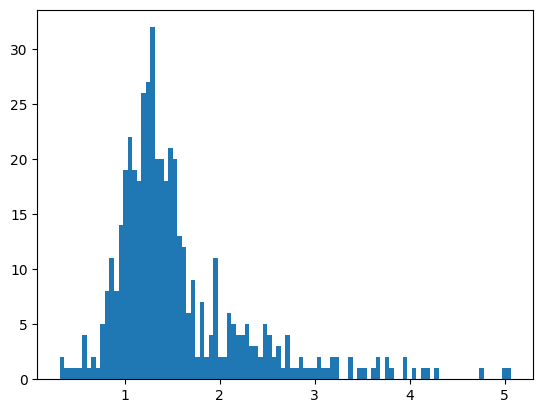

In [51]:
flipped_data = [(y, x) if x < y else (x, y) for x, y in orig_dims]
aspect_ratio = [x/y for x, y in orig_dims]
np.median(aspect_ratio)
x_data = [x for x, y in flipped_data]
y_data = [y for x, y in flipped_data]
#plt.scatter(x_data, y_data)
plt.hist(aspect_ratio, bins=100)

In [41]:
np.corrcoef(x_data, y_data)[0,1]

0.6368423024398109

In [31]:
scene.size

(159234, 70182)

Image (0, 0, 159234, 70182) 3


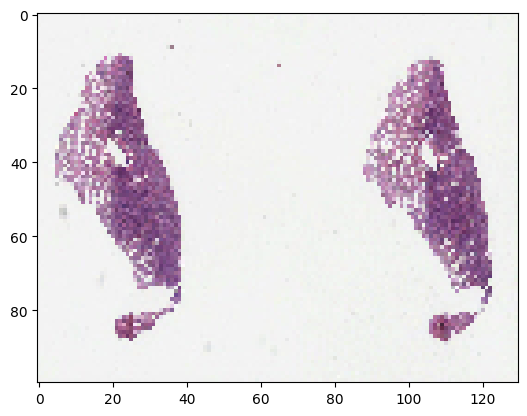

In [20]:
slide = slideio.open_slide(ex, driver='SVS')
scene = slide.get_scene(0)
print(scene.name, scene.rect, scene.num_channels)
square_image = scene.read_block(size = (130, 100))
plt.imshow(square_image)

In [17]:
images = os.listdir(IMAGE_PATH)
case_for_img = []
for img in images:
    case_for_img.append(os.path.splitext(img)[0])
case_for_img[0:10]

['TCGA-MP-A4T8',
 'TCGA-NJ-A4YF',
 'TCGA-93-A4JP',
 'TCGA-50-6595',
 'TCGA-NJ-A7XG',
 'TCGA-49-4487',
 'TCGA-05-4384',
 'TCGA-86-7953',
 'TCGA-75-6205',
 'TCGA-49-6767']

In [18]:
j = 0
case_and_image = {}
for i, case in enumerate(cases):
    p = get_FFPE_images(case)
    if p is not None and case in case_for_img:
        case_and_image[case] = p
        j+=1
print(f"{j} cases out of {len(cases)} have FFPE images and have a generated JPEG")

No DX found for case TCGA-50-5049
No DX found for case TCGA-62-8394
No DX found for case TCGA-50-5933
No DX found for case TCGA-50-5936
No DX found for case TCGA-91-6831
No DX found for case TCGA-91-8499
No DX found for case TCGA-50-5932
No DX found for case TCGA-91-6848
No DX found for case TCGA-91-6836
No DX found for case TCGA-05-4389
No DX found for case TCGA-50-5930
No DX found for case TCGA-50-5072
No DX found for case TCGA-44-8117
No DX found for case TCGA-97-8174
No DX found for case TCGA-67-3776
No DX found for case TCGA-50-6595
No DX found for case TCGA-44-8120
No DX found for case TCGA-91-6835
No DX found for case TCGA-91-8496
No DX found for case TCGA-97-8176
No DX found for case TCGA-50-8460
No DX found for case TCGA-50-5935
No DX found for case TCGA-91-6847
No DX found for case TCGA-50-5944
No DX found for case TCGA-91-7771
No DX found for case TCGA-91-6849
No DX found for case TCGA-50-5941
No DX found for case TCGA-62-8395
No DX found for case TCGA-91-6840
No DX found fo

In [19]:
all_images_data = pd.DataFrame.from_dict(case_and_image, orient='index', columns=['image_path']).reset_index(\
                                                      ).rename(columns={'index':'case_id'})
all_images_data.head()

,case_id,image_path
0,TCGA-35-4122,/users/anair27/data/TCGA_Data/project_LUAD/dat...
1,TCGA-75-6203,/users/anair27/data/TCGA_Data/project_LUAD/dat...
2,TCGA-75-5146,/users/anair27/data/TCGA_Data/project_LUAD/dat...
3,TCGA-78-8648,/users/anair27/data/TCGA_Data/project_LUAD/dat...
4,TCGA-55-A4DG,/users/anair27/data/TCGA_Data/project_LUAD/dat...


In [20]:
all_images_data.to_csv(DESTINATION_DATA_PATH)

In [21]:
import openslide
import PIL
import os
import numpy as np
from openslide.deepzoom import DeepZoomGenerator

In [22]:
os.chdir('/users/anair27/data/TCGA_Data/project_LUAD/data_by_cases')

In [23]:
slide = openslide.open_slide('./TCGA-NJ-A4YG/images/TCGA-NJ-A4YG-01Z-00-DX1.507BAE41-5EE9-4657-AAD1-AD456750BA2F.svs')
slide

OpenSlide('./TCGA-NJ-A4YG/images/TCGA-NJ-A4YG-01Z-00-DX1.507BAE41-5EE9-4657-AAD1-AD456750BA2F.svs')

In [24]:
print(slide.dimensions)

(197207, 77830)


In [25]:
tn = slide.get_thumbnail(size = (600, 600))

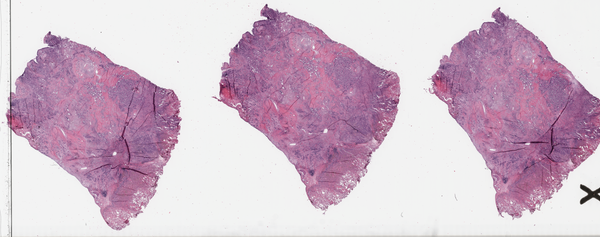

In [29]:
tn

In [119]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap = 0, limit_bounds = False)
cols, rows = tiles.level_tiles[15]
#     for col in range(cols):
#         for row in range(rows):
#             tile_name = os.path.join(output, f"{case}_{col}_{row}_l{level}.png")
#             t_tile = tiles.get_tile(level, (col, row))

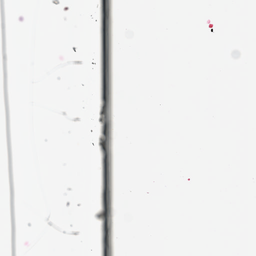

In [120]:
tiles.get_tile(13, (0,0))

In [129]:
from deephistopath.wsi.tiles import score_tile

In [130]:
score_tile(tiles.get_tile(15, (0,0)))

TypeError: score_tile() missing 4 required positional arguments: 'tissue_percent', 'slide_num', 'row', and 'col'

In [110]:
t_tile = tiles.get_tile(11, (1, 1))

OpenSlideError: Cannot set TIFF directory 2

In [14]:
np.array(tn).shape

(237, 600, 3)

In [16]:
cases = os.listdir(".")
cases_small = cases[0:20]

In [22]:
for case in cases:
    print(case)
    img_files = os.listdir(f"./{case}/images")
    for f in img_files:
        print(f.split('.')[0][-3:-1])

TCGA-35-4122
TS
BS
DX
TCGA-75-6203
BS
TS
DX
TCGA-75-5146
TS
BS
DX
TCGA-78-8648
DX
TS
TCGA-55-A4DG
DX
TS
TCGA-MP-A4SY
TS
DX
TCGA-67-3771
TS
DX
BS
TCGA-44-A479
DX
TS
TCGA-78-7156
TS
DX
BS
TCGA-55-7724
DX
TS
TCGA-78-7149
DX
BS
TS
TCGA-55-A4DF
TS
DX
TCGA-55-8207
TS
DX
TCGA-78-7145
TS
DX
BS
TCGA-97-A4M0
TS
DX
TCGA-05-5428
DX
TS
BS
TCGA-55-8510
TS
DX
TCGA-64-5774
TS
BS
DX
TCGA-75-7025
TS
DX
TCGA-97-8175
DX
TS
TCGA-99-7458
TS
DX
BS
TCGA-55-A492
TS
DX
TCGA-44-7670
DX
TS
TS
BS
TCGA-50-5049
TS
BS
TCGA-86-8359
BS
TS
DX
TCGA-55-7907
TS
TS
DX
TCGA-44-4112
TS
TS
BS
TS
BS
TS
TS
TS
DX
BS
BS
TCGA-MN-A4N4
TS
DX
DX
TCGA-75-7031
BS
TS
DX
TCGA-MP-A4T6
TS
DX
TCGA-38-4627
BS
DX
BS
TS
TS
TCGA-44-2666
TS
TS
DX
BS
BS
TS
TS
BS
TCGA-44-7660
DX
TS
TS
BS
TCGA-49-6743
DX
TS
BS
DX
DX
DX
TS
TCGA-05-4245
TS
BS
DX
TCGA-91-A4BD
DX
TS
TCGA-44-8119
TS
TS
BS
DX
TCGA-38-4628
TS
BS
TS
BS
DX
TCGA-86-8671
TS
BS
DX
TCGA-62-8394
TS
BS
TS
TCGA-44-2656
TS
BS
TS
TS
BS
TS
TS
BS
BS
DX
TCGA-99-8032
TS
DX
TS
TCGA-78-7163
DX
TS
TS
BS
TCG

DX
TS
TCGA-91-8497
TS
BS
TCGA-75-5122
TS
DX
BS
TCGA-05-4250
TS
BS
DX
TCGA-49-6761
BS
TS
DX
TCGA-05-4396
BS
DX
BS
TCGA-50-6593
TS
TS
DX
BS
TCGA-62-8402
TS
TS
TCGA-99-8028
TS
TS
DX
TCGA-44-7669
DX
BS
TS
TCGA-67-3770
DX
TS
TCGA-44-6775
TS
BS
TS
DX
BS
TS
TS
BS
TS
TCGA-44-7659
TS
TS
BS
DX
TCGA-97-8547
TS
TCGA-50-5045
BS
TS
DX
DX
TCGA-05-4427
BS
BS
DX
TCGA-97-A4M6
DX
TS
TCGA-44-3396
TS
DX
TS
BS
TCGA-55-6543
DX
BS
TS
TCGA-MP-A4T7
TS
DX
TCGA-86-8673
DX
BS
TS
TCGA-73-4666
TS
DX
TS
BS
BS
TCGA-55-8090
DX
TS
TCGA-73-4670
BS
TS
DX
TS
BS
TCGA-73-4668
BS
BS
DX
TS
TS
TCGA-05-4422
BS
TS
DX
TCGA-86-7714
DX
BS
TS
TCGA-64-5775
BS
TS
DX
TCGA-05-4418
BS
DX
TS
TCGA-62-8398
TS
BS
TS
TCGA-55-8097
TS
DX
TCGA-S2-AA1A
DX
TS


In [26]:
def get_FFPE_images(case):
    img_files = os.listdir(f"./{case}/images")
    for f in img_files:
        if (f.split('.')[0][-3:-1] == 'DX'):
            return f"./{case}/images/{f}"
    print("No DX found for case ",case)
    return None

In [30]:
FFPE_image_paths = []
for case in cases:
    p = get_FFPE_images(case)
    if p is not None:
        FFPE_image_paths.append(p)
FFPE_image_paths

No DX found for case  TCGA-50-5049
No DX found for case  TCGA-62-8394
No DX found for case  TCGA-50-5933
No DX found for case  TCGA-50-5936
No DX found for case  TCGA-91-6831
No DX found for case  TCGA-91-8499
No DX found for case  TCGA-50-5932
No DX found for case  TCGA-91-6848
No DX found for case  TCGA-91-6836
No DX found for case  TCGA-05-4389
No DX found for case  TCGA-50-5930
No DX found for case  TCGA-50-5072
No DX found for case  TCGA-44-8117
No DX found for case  TCGA-97-8174
No DX found for case  TCGA-67-3776
No DX found for case  TCGA-50-6595
No DX found for case  TCGA-44-8120
No DX found for case  TCGA-91-6835
No DX found for case  TCGA-91-8496
No DX found for case  TCGA-97-8176
No DX found for case  TCGA-50-8460
No DX found for case  TCGA-50-5935
No DX found for case  TCGA-91-6847
No DX found for case  TCGA-50-5944
No DX found for case  TCGA-91-7771
No DX found for case  TCGA-91-6849
No DX found for case  TCGA-50-5941
No DX found for case  TCGA-62-8395
No DX found for case

['./TCGA-35-4122/images/TCGA-35-4122-01Z-00-DX1.2ac022e4-e796-49e5-9a24-f0ff3f76a527.svs',
 './TCGA-75-6203/images/TCGA-75-6203-01Z-00-DX1.9796ACAB-9E1A-4BC5-B80C-4EC856FA14B7.svs',
 './TCGA-75-5146/images/TCGA-75-5146-01Z-00-DX1.4958A631-7E6F-4FBB-A1C3-B8F8368D46C5.svs',
 './TCGA-78-8648/images/TCGA-78-8648-01Z-00-DX1.D3EAEF8E-E739-490F-BF48-A4796B0C0E7A.svs',
 './TCGA-55-A4DG/images/TCGA-55-A4DG-01Z-00-DX1.9CE9B7BE-48EF-44F1-9C25-F15700A3E5DE.svs',
 './TCGA-MP-A4SY/images/TCGA-MP-A4SY-01Z-00-DX1.9535274F-C850-409E-80A1-B933B2F1A110.svs',
 './TCGA-67-3771/images/TCGA-67-3771-01Z-00-DX1.7B54D132-6AB7-4F2D-8BFF-33AFE83CF204.svs',
 './TCGA-44-A479/images/TCGA-44-A479-01Z-00-DX1.CA5654C6-A623-452E-A8AC-DB6279CA97B1.svs',
 './TCGA-78-7156/images/TCGA-78-7156-01Z-00-DX1.9f7c8eb9-73de-49be-a487-e1fd4411b7b5.svs',
 './TCGA-55-7724/images/TCGA-55-7724-01Z-00-DX1.31a194ac-62e3-4225-8e32-8c2a83dcdd10.svs',
 './TCGA-78-7149/images/TCGA-78-7149-01Z-00-DX1.1b83dbcb-0c9f-4e50-bb98-bf9a157052cf.svs',

In [34]:
def get_thumbnail(filepath, shape):
    slide = openslide.open_slide(filepath)
    tn = slide.get_thumbnail(size = (600, 600))
    tn
    print(f"shape: {np.array(tn).shape}")


In [35]:
for image in FFPE_image_paths[0:20]:
    get_thumbnail(image, (60, 60))

shape: (264, 600, 3)
shape: (166, 600, 3)
shape: (491, 600, 3)
shape: (496, 600, 3)
shape: (517, 600, 3)
shape: (362, 600, 3)
shape: (187, 600, 3)
shape: (219, 600, 3)
shape: (507, 600, 3)
shape: (369, 600, 3)
shape: (441, 600, 3)
shape: (600, 571, 3)
shape: (561, 600, 3)
shape: (445, 600, 3)
shape: (412, 600, 3)
shape: (371, 600, 3)
shape: (600, 346, 3)
shape: (600, 566, 3)
shape: (432, 600, 3)
shape: (388, 600, 3)


In [90]:
def save_tiles(case, filepath, output, tile_size = 256, level = 15):
    slide = openslide.open_slide(filepath)
    tiles = DeepZoomGenerator(slide, tile_size=tile_size, overlap = 0, limit_bounds = False)
    cols, rows = tiles.level_tiles[level]
    for col in range(cols):
        for row in range(rows):
            tile_name = os.path.join(output, f"{case}_{col}_{row}_l{level}.png")
            t_tile = tiles.get_tile(level, (col, row))
            arr = np.array(t_tile.convert('RGB'))
            plt.imsave(tile_name, arr)


In [ ]:
def generate_tiles(cases, survival_data):
    case_to_path = {}
    for case in cases:
        image_path = get_FFPE_images(case)
        if image_path is not None:
            case_to_path[case] = image_path
    for case, image_path in enumerate(case_to_path):
        vital = survival_data.set_index('case_id').loc[case]['vital_status_Dead']
        if vital == 0:
            survival_dir = 0
        else:
            survival_dir = 1
        save_tiles(case, image_path, survival_dir)

In [94]:
os.chdir("/users/anair27/data/anair27")

In [95]:
clinical = pd.read_csv("./singh-lab-TCGA-project/MADDi_model/MADDi/preprocess_clinical/processed_clinical.csv")

In [96]:
diagnosis = clinical[["vital_status_Dead", "case_id"]]
diagnosis.head(10)

,vital_status_Dead,case_id
0,0,TCGA-78-8640
1,0,TCGA-05-5425
2,0,TCGA-55-7815
3,1,TCGA-44-7661
4,0,TCGA-97-7554
5,1,TCGA-J2-A4AD
6,1,TCGA-55-6981
7,0,TCGA-86-8281
8,1,TCGA-44-A4SU
9,1,TCGA-93-A4JO


In [102]:
diagnosis.set_index('case_id').loc['TCGA-44-7661']['vital_status_Dead']

1

In [91]:
!pwd

/gpfs/data/rsingh47/TCGA_Data/project_LUAD/data_processed/imaging_data/tiles


In [92]:
os.chdir('/users/anair27/data/TCGA_Data/project_LUAD/data_processed/imaging_data/tiles')

In [93]:
save_tiles('TCGA-35-4122', '/users/anair27/data/TCGA_Data/project_LUAD/data_by_cases/TCGA-35-4122/images/TCGA-35-4122-01Z-00-DX1.2ac022e4-e796-49e5-9a24-f0ff3f76a527.svs', '')

In [42]:
levels = []
for image in FFPE_image_paths:
    levels.append(get_tiles(image))

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [60]:
strings = [str(x) for x in levels]

In [62]:
strings

['19',
 '18',
 '16',
 '18',
 '16',
 '18',
 '19',
 '19',
 '18',
 '17',
 '18',
 '17',
 '15',
 '18',
 '18',
 '15',
 '17',
 '17',
 '16',
 '19',
 '17',
 '18',
 '19',
 '19',
 '17',
 '18',
 '18',
 '16',
 '18',
 '19',
 '18',
 '18',
 '18',
 '18',
 '18',
 '17',
 '18',
 '17',
 '18',
 '18',
 '18',
 '15',
 '18',
 '19',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '19',
 '18',
 '18',
 '18',
 '18',
 '18',
 '17',
 '18',
 '15',
 '17',
 '18',
 '18',
 '18',
 '18',
 '18',
 '17',
 '18',
 '18',
 '17',
 '18',
 '15',
 '16',
 '17',
 '18',
 '18',
 '18',
 '17',
 '17',
 '18',
 '18',
 '18',
 '19',
 '19',
 '18',
 '19',
 '18',
 '19',
 '18',
 '18',
 '16',
 '18',
 '18',
 '18',
 '17',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '19',
 '18',
 '19',
 '17',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '19',
 '18',
 '18',
 '18',
 '17',
 '18',
 '16',
 '18',
 '18',
 '18',
 '18',
 '18',
 '18',
 '17',
 '18',
 '15',
 '18',
 '18',
 '18',
 '17',
 '18',
 '19',
 '18',

In [69]:
import pandas as pd
df = pd.DataFrame(levels)

In [70]:
df

,0
0,19
1,18
2,16
3,18
4,16
...,...
472,18
473,17
474,18
475,16


<AxesSubplot: xlabel='0', ylabel='count'>

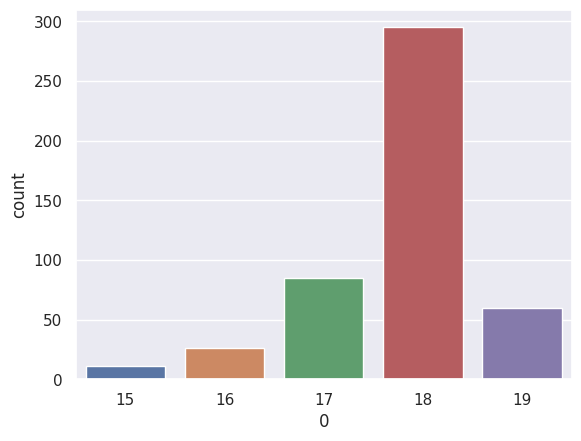

In [72]:
sns.countplot(x=0, data = df)

In [131]:
!conda info



     active environment : akira_conda
    active env location : /users/anair27/anaconda/akira_conda
            shell level : 1
       user config file : /users/anair27/.condarc
 populated config files : /gpfs/runtime/opt/anaconda/2022.05/.condarc
                          /users/anair27/.condarc
          conda version : 4.12.0
    conda-build version : 3.21.8
         python version : 3.9.12.final.0
       virtual packages : __linux=3.10.0=0
                          __glibc=2.17=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /gpfs/runtime/opt/anaconda/2022.05  (read only)
      conda av data dir : /gpfs/runtime/opt/anaconda/2022.05/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anac